In [1]:
% matplotlib inline

import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('white')

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
from glob import glob 
import os
from tqdm import tqdm_notebook as tqdm 
from itertools import product

import numpy as np
import scipy.ndimage
import cv2
from multiprocessing import Pool

import sys
sys.path.append('../scripts')
sys.path.append('../nets')
import load_utils
import watereshed
import generator_3D
import unet

from keras.callbacks import ModelCheckpoint
import pandas as pd

import warnings
warnings.filterwarnings('ignore')


from skimage import measure
from skimage.morphology import convex_hull_image

import pickle
from skimage.measure import regionprops

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
PATHS = {
    'DATA': '/home/ubuntu/cdata/DM_Data/RIII',
    'DESC': '/home/ubuntu/cdata/DM_Data/REPRISEIIISizes.xlsx'
}


SIDE = 224
BATCH_SIZE = 32
SPLIT = .15

In [4]:
def load(path, random=True, standardize=True):
    if os.path.basename(os.path.dirname(path)) == 'raw':
        patches = glob(os.path.join(path, 'patch*.npy'))
        patch = np.load(patches[np.random.randint(len(patches))])
        if standardize:

            return np.dstack([
                scipy.ndimage.zoom(patch[..., 0], .7),
                scipy.ndimage.zoom(patch[..., -1], .7, order=0)
            ])
        
        return patch
    
    patch = np.load(os.path.join(path, 'patch.npy'))
    if random:
        return patch[np.random.randint(len(patch))]
    return patch[0]

In [5]:
def preprocess_test(patch):
    window = min(patch.shape[1], int(1.7 * SIDE))
    point = np.array(patch.shape) // 2 - window // 2
    point = np.clip(point, 0, np.array(patch.shape) - window)
    patch = patch[
        point[0]: point[0] + window, 
        point[1]: point[1] + window
    ]

    clip = cv2.resize(patch, dsize=(SIDE, SIDE))
    return clip


def preprocess_val(patch):
    window = min(patch.shape[1], int(1.7 * SIDE))
    point = np.array(patch.shape[:-1]) // 2 - window // 2
    point = np.clip(point, 0, np.array(patch.shape[:-1]) - window)
    
    patch = patch[
        point[0]: point[0] + window, 
        point[1]: point[1] + window
    ]

    return np.dstack([
        scipy.ndimage.zoom(patch[..., 0], SIDE / patch.shape[0]),
        scipy.ndimage.zoom(patch[..., -1], SIDE / patch.shape[0], order=0)
    ])


def preprocess_train(patch):
    if np.random.randint(2):
        patch = np.flip(patch, 0)
    
    if np.random.randint(2):
        patch = np.flip(patch, 1)
    
    if np.random.randint(3):
        shift = np.random.uniform(-.2, .2, size=2)
        shift *= np.array(patch.shape[:2])
        patch = np.dstack([
            scipy.ndimage.shift(patch[..., 0], shift),
            scipy.ndimage.shift(patch[..., -1], shift, order=0)
        ])
        
    if np.random.randint(3):
        rotate = np.random.uniform(-40, 40)
        patch = np.dstack([
            scipy.ndimage.rotate(patch[..., :-1], rotate),
            scipy.ndimage.rotate(patch[..., -1:], rotate, order=0)
        ])
    
    scale = np.random.uniform(.5, 1.5)
    window = min(min(patch.shape[:-1]), int(SIDE * scale))
    if np.count_nonzero(patch[..., 1]):
        coords = np.array(np.where(patch[..., 1]))
        cmin, cmax = coords.min(1) - window, coords.max(1)
        point = np.array([
            np.random.randint(cmin[0], cmax[0]),
            np.random.randint(cmin[1], cmax[1])
        ])
    else:
        point = np.random.randint(0, min(patch.shape[:-1]) - window + 1)
    point = np.clip(point, 0, np.array(patch.shape[:-1]) - window)
    
    patch = patch[
        point[0]: point[0] + window, 
        point[1]: point[1] + window
    ]

    return np.dstack([
        scipy.ndimage.zoom(patch[..., 0], SIDE / patch.shape[0]),
        scipy.ndimage.zoom(patch[..., -1], SIDE / patch.shape[0], order=0)
    ])

In [6]:
def eval_generator(patient, batch_size=BATCH_SIZE):
    for i in range(len(patient) // batch_size + 1):
        batch = patient[i * batch_size: (i + 1) * batch_size]
        processed = list(map(preprocess_val, batch))
        processed = np.array(processed)
        yield (np.expand_dims(processed[..., 0], -1) + 199.) / 461., np.expand_dims(processed[..., 1], -1) > 0
        

def test_generator(patient, train_mode=False, batch_size=BATCH_SIZE):
    for i in range(len(patient) // batch_size + 1):
        batch = patient[i * batch_size: (i + 1) * batch_size]
        processed = list(map(preprocess_test, batch))
        processed = np.array(processed)
        yield (np.expand_dims(processed, -1) + 199.) / 461.
        

def generator(paths, train_mode=False, batch_size=BATCH_SIZE, shuffle_coef=.7):
    while True:
        paths = [
            os.path.join(
                os.path.dirname(os.path.dirname(path)), 
                os.path.basename(path)
            ) 
            if os.path.basename(os.path.dirname(path)) == 'raw'
            else path
            for path in paths
        ]
        if train_mode:
            np.random.shuffle(paths)
            paths = [
                os.path.join(os.path.dirname(path), 'raw', os.path.basename(path)) 
                if shuffle_coef * len(paths) >= i 
                else path 
                for i, path in enumerate(paths)
            ]
            np.random.shuffle(paths)
            
        for i in range(len(paths) // batch_size + 1):
            batch = paths[i * batch_size: (i + 1) * batch_size]
            with Pool(4) as pool:
                processed = pool.map(load, batch)

            if train_mode:
                with Pool(14) as pool:
                    processed = pool.map(preprocess_train, processed)
            else:
                with Pool(14) as pool:
                    processed = pool.map(preprocess_val, processed)
            processed = np.array(processed)
            yield (np.expand_dims(processed[..., 0], -1) + 199.) / 461., np.expand_dims(processed[..., 1], -1) > 0

In [7]:
zis_paths = glob(os.path.join(PATHS['DATA'], '*', 'zis.npy'))
prods_paths = [os.path.join(os.path.dirname(path), 'prods.npy') for path in zis_paths]

# Inference

In [8]:
model = unet.get_unet(224, 224)
model.load_weights(os.path.join(PATHS['DATA'], 'unet_model'))

In [9]:
from IPython.display import clear_output

In [11]:
i = 18

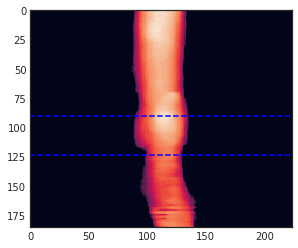

[ 90 124]


In [ ]:
while i <= len(zis_paths):
    clear_output()
    print('Iteration: %d / %d' % (i, len(zis_paths)))
    print(os.path.basename(os.path.dirname(zis_paths[i])))
    
    zis = np.load(zis_paths[i])
    prods = np.load(prods_paths[i])
    zis = np.stack(zis, 0)

    p = model.predict(zis)
#     p1 = model.predict(np.flip(zis, 1))
#     p2 = model.predict(np.flip(zis, 2))
#     p3 = model.predict(np.flip(np.flip(zis, 1), 2))
    lpred = np.mean(
        np.stack([
            p, 
#             np.flip(p1, 1), 
#             np.flip(p2, 2), 
#             np.flip(np.flip(p3, 1), 2)
        ], -1), 
        -1
    )
    
    tangs = list()
    large = list()
    small = list()
    for mi in lpred[..., 0]:
        mask, _ = scipy.ndimage.label(mi > .5)
        try:
            idx = np.argmax(np.bincount(mask.flatten())[1:]) + 1
            mask = mask == idx
            rgroup = regionprops(mask.astype(np.int))[0]
            large.append(rgroup.major_axis_length)
            small.append(rgroup.minor_axis_length)
        except:
            tangs.append(0)
            continue

    l = np.array([0 if np.isnan(l) or np.isnan(s) else l for l, s in zip(large, small)])
    s = np.array([0 if np.isnan(l) or np.isnan(s) else s for l, s in zip(large, small)])

    tangs = l
    tangs = scipy.ndimage.gaussian_filter1d(tangs, 3)
    args = scipy.signal.argrelextrema(tangs, np.less_equal, order=1)[0]
    args = args[tangs[args] > 5]


    while True:
        clear_output()
        print('Iteration: %d / %d' % (i, len(zis_paths)))
        print(os.path.basename(os.path.dirname(zis_paths[i])))

        print(list(zip(np.arange(len(args)), args)))
        plt.plot(np.arange(len(tangs)), tangs)
        plt.scatter(args, tangs[args], c='r')
        plt.show()
        plt.imshow((lpred[..., 0] > .5).sum(1))
        for el in args:
            plt.plot([0, lpred.shape[1] - 1], [el, el], '--', c='b')
        plt.show()
        while True:
            try:
                idxs = input()
                if idxs == 'stop' or idxs == 'skip' or idxs == 'back':
                    break
                idxs = [int(idx) for idx in  idxs.split(' ')]
                idxs = idxs
                if len(idxs) != 2:
                    continue
                break
            except:
                pass

        if idxs == 'stop' or idxs == 'skip' or idxs == 'back':
            break


        cols = 3
        rows = int(np.ceil((idxs[1] - idxs[0]) / cols))
        for k in range(rows):
            print(idxs[0] + k * cols)
            f, axs = plt.subplots(1, cols, figsize=(15,15))
            for j in range(cols):
                plt.subplot(1, cols, j + 1)
                plt.imshow(zis[idxs[0] + k * cols + j, ..., 0])
                plt.axis('off')
            plt.show()
                
        while True:
            try:
                idxs = input()
                if idxs == 'stop':
                    break
                idxs = np.array([int(idx) for idx in  idxs.split(' ')])
                if len(idxs) != 2:
                    continue
                break
            except:
                pass

        clear_output()
        plt.imshow(lpred[..., 0].sum(1))
        for el in idxs:
            plt.plot([0, lpred.shape[1] - 1], [el, el], '--', c='b')
        plt.show()
        
        np.save(os.path.join(os.path.dirname(zis_paths[i]), 'idxs'), idxs)
        print(np.load(os.path.join(os.path.dirname(zis_paths[i]), 'idxs.npy')))
        if not input('Continue?'):
            break
    if  idxs == 'back':
        i -= 1
        continue
    if idxs == 'stop':
        break
    i += 1
    if idxs == 'skip':
        continue